In [1]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.utils import class_weight
import numpy as np

In [2]:
# Step 1: Load the dataset
def load_dataset(data_dir, img_height, img_width, batch_size, validation_split=0.2):
    train_ds = tf.keras.utils.image_dataset_from_directory(
        data_dir,
        validation_split=validation_split,
        subset='training',
        seed=42,
        image_size=(img_height, img_width),
        batch_size=batch_size,
        shuffle=True
    )

    val_ds = tf.keras.utils.image_dataset_from_directory(
        data_dir,
        validation_split=validation_split,
        subset='validation',
        seed=42,
        image_size=(img_height, img_width),
        batch_size=batch_size,
        shuffle=True
    )

    return train_ds, val_ds

In [3]:
# Define parameters
data_dir = '/kaggle/input/faulty-solar-panel-images/Faulty_solar_panel'
img_height, img_width = 224, 224
batch_size = 32

In [4]:
# Load the dataset
train_ds, val_ds = load_dataset(data_dir, img_height, img_width, batch_size)

Found 4372 files belonging to 6 classes.
Using 3498 files for training.
Found 4372 files belonging to 6 classes.
Using 874 files for validation.


In [5]:
# Step 2: Preprocess the dataset
normalization_layer = tf.keras.layers.Rescaling(1./255)
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))

In [6]:
# Step 3: Handle class imbalance
# Compute class weights
labels = []
for _, label_batch in train_ds:
    labels.extend(label_batch.numpy())
labels = np.array(labels)

class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(labels), y=labels)
class_weights = dict(enumerate(class_weights))
print("Class Weights:", class_weights)

Class Weights: {0: 1.0282186948853616, 1: 0.7691292875989446, 2: 1.1020793950850662, 3: 2.191729323308271, 4: 0.5632850241545894, 5: 1.6997084548104957}


In [7]:
# Step 4: Build the model
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))
base_model.trainable = True
for layer in base_model.layers[:100]:  # Freeze the first 100 layers
    layer.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(6, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)
model.summary()

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1 (Conv2D)            │ (None, 112, 112, 32)   │            864 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn_Conv1                  │ (None, 112, 112, 32)   │            128 │ Conv1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1_relu (ReLU)         │ (None, 112, 112, 32)   │              0 │ bn_Conv1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise   │ (None, 112, 112, 32)   │            288 │ Conv1_relu[0][0]       │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │            128 │ expanded_conv_depthwi… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │              0 │ expanded_conv_depthwi… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project     │ (None, 112, 112, 16)   │            512 │ expanded_conv_depthwi… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project_BN  │ (None, 112, 112, 16)   │             64 │ expanded_conv_project… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand (Conv2D)   │ (None, 112, 112, 96)   │          1,536 │ expanded_conv_project… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_BN         │ (None, 112, 112, 96)   │            384 │ block_1_expand[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_relu       │ (None, 112, 112, 96)   │              0 │ block_1_expand_BN[0][… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_pad               │ (None, 113, 113, 96)   │              0 │ block_1_expand_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise         │ (None, 56, 56, 96)     │            864 │ block_1_pad[0][0]      │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise_BN 

 Total params: 2,619,590 (9.99 MB)

 Trainable params: 2,223,046 (8.48 MB)

 Non-trainable params: 396,544 (1.51 MB)

In [8]:
# Step 5: Compile the model
optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [9]:

# Step 6: Train the model
epochs = 30
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    class_weight=class_weights
)

Epoch 1/30
110/110 ━━━━━━━━━━━━━━━━━━━━ 50s 233ms/step - accuracy: 0.2314 - loss: 1.9600 - val_accuracy: 0.5069 - val_loss: 1.3307
Epoch 2/30
110/110 ━━━━━━━━━━━━━━━━━━━━ 11s 99ms/step - accuracy: 0.5857 - loss: 1.0911 - val_accuracy: 0.5332 - val_loss: 1.1959
Epoch 3/30
110/110 ━━━━━━━━━━━━━━━━━━━━ 9s 84ms/step - accuracy: 0.7359 - loss: 0.6805 - val_accuracy: 0.6442 - val_loss: 1.0876
Epoch 4/30
110/110 ━━━━━━━━━━━━━━━━━━━━ 11s 99ms/step - accuracy: 0.8605 - loss: 0.4237 - val_accuracy: 0.7620 - val_loss: 0.7412
Epoch 5/30
110/110 ━━━━━━━━━━━━━━━━━━━━ 11s 99ms/step - accuracy: 0.8922 - loss: 0.3152 - val_accuracy: 0.7414 - val_loss: 0.8515
Epoch 6/30
110/110 ━━━━━━━━━━━━━━━━━━━━ 11s 100ms/step - accuracy: 0.9457 - loss: 0.1660 - val_accuracy: 0.7883 - val_loss: 0.7492
Epoch 7/30
110/110 ━━━━━━━━━━━━━━━━━━━━ 12s 105ms/step - accuracy: 0.9616 - loss: 0.1341 - val_accuracy: 0.8570 - val_loss: 0.5199
Epoch 8/30
110/110 ━━━━━━━━━━━━━━━━━━━━ 10s 90ms/step - accuracy: 0.9679 - loss: 0.1033 

In [10]:
# Step 7: Evaluate the model
loss, accuracy = model.evaluate(val_ds)
print(f"Validation Accuracy: {accuracy * 100:.2f}%")

28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 77ms/step - accuracy: 0.9595 - loss: 0.3164
Validation Accuracy: 95.19%


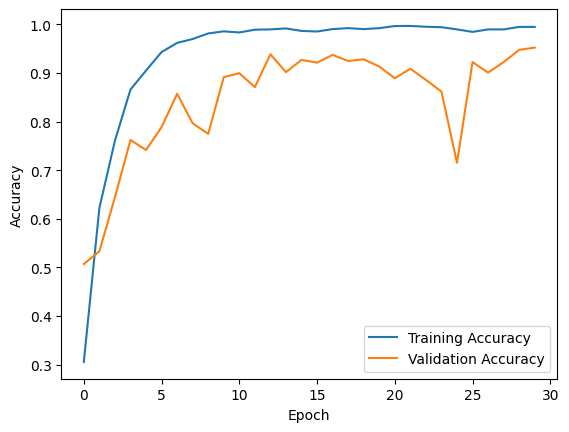

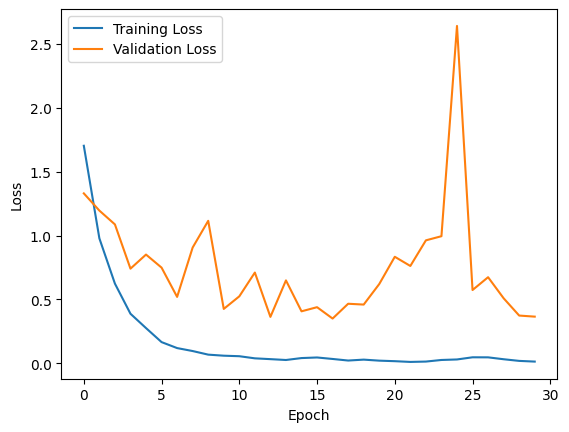

In [12]:
import numpy as np
import matplotlib.pyplot as plt
# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [18]:

# Step 8: Save the model
model.save('solar_panel_model_final1.h5')
print("Model saved as solar_panel_model.h5")

Model saved as solar_panel_model.h5


In [19]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import numpy as np
# Define class labels
class_labels = ['Bird-drop', 'Clean', 'Dusty', 'Electrical-damage', 'Physical-Damage', 'Snow-Covered']

In [20]:
def preprocess_image(img_path, target_size=(224, 224)):
    img = image.load_img(img_path, target_size=target_size)  # Load image and resize
    img_array = image.img_to_array(img)  # Convert to NumPy array
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array = img_array / 255.0  # Normalize pixel values
    return img_array


In [21]:
def predict_image(img_path):
    img_array = preprocess_image(img_path)  # Preprocess image
    predictions = model.predict(img_array)  # Make predictions

    predicted_class_index = np.argmax(predictions, axis=1)[0]  # Get class index
    predicted_class = class_labels[predicted_class_index]  # Get class name
    confidence = float(predictions[0][predicted_class_index])  # Get confidence score

    return predicted_class, confidence


In [22]:
image_path = "/kaggle/input/faults/thumb.jpg"  
predicted_class, confidence = predict_image(image_path)

print(f"Predicted Class: {predicted_class}")
print(f"Confidence Score: {confidence:.4f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Predicted Class: Physical-Damage
Confidence Score: 0.9973


In [23]:
image_path = "/kaggle/input/faults/dust.jpg"  
predicted_class, confidence = predict_image(image_path)

print(f"Predicted Class: {predicted_class}")
print(f"Confidence Score: {confidence:.4f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Predicted Class: Dusty
Confidence Score: 1.0000
